In [13]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing

In [14]:
# Cov matrix
def cov(lam1, lam2, theta):
    d = np.matrix([[lam1, 0], [0, lam2]])
    p = np.matrix([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    invp = np.linalg.inv(p)
    return np.linalg.multi_dot((p,d,invp))

# Generating Data
def gendata(data_pts):
    
    data_pts = data_pts/2
    
    # Class 0
    cov0 = cov(2, 1, 0)
    mean0 = [0,0]

    data0 = np.random.multivariate_normal(mean0, cov0, data_pts)

    # Class 1

    cov1a = cov(2, 0.25, -3*np.pi/4)
    mean1a = [-2,1]
    cov1b = cov(3, 1, np.pi/4)
    mean1b = [3,2]

    data1a = np.random.multivariate_normal(mean1a, cov1a, (data_pts/3))
    data1b = np.random.multivariate_normal(mean1b, cov1b, (data_pts - data_pts/3))
    data1 = np.concatenate((data1a, data1b), axis=0)

    data = np.concatenate((data0,data1), axis = 0)
    labels = np.concatenate((np.zeros(data_pts), np.ones(data_pts)))

    return data,labels

def plotdata(x,y):
    for i in range(y.shape[0]):
        if(y[i] == 0):
            plt.plot(x[i,0], x[i,1], 'o', color = 'red')
        else:
            plt.plot(x[i,0], x[i,1], 'x', color = 'blue')

In [15]:
data_size = 2000
# data, labels = gendata(data_size)
# np.save('data_2', data)
# np.save('labels_2',labels)

Training Data Size = 1280
Testing  Data Size = 400
Validation Data Size = 320


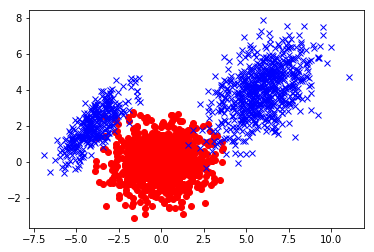

In [132]:
data = np.load('data_2.npy')
labels = np.load('labels_2.npy')

# data_scaled = preprocessing.scale(data)

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=15)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=25)

# x_train_scaled, x_test_scaled, y_train, y_test = train_test_split(data_scaled, labels, test_size=0.2, random_state=15)
# x_train_scaled, x_valid_scaled, y_train, y_valid = train_test_split(x_train_scaled, y_train, test_size=0.2, random_state=25)


onehot_encoder = OneHotEncoder(sparse=False)
y_train_onehot = onehot_encoder.fit_transform(y_train.reshape((-1,1)))
y_test_onehot = onehot_encoder.fit_transform(y_test.reshape((-1,1)))
y_valid_onehot = onehot_encoder.fit_transform(y_valid.reshape((-1,1)))

print("Training Data Size = {}".format(y_train.shape[0]))
print("Testing  Data Size = {}".format(y_test.shape[0]))
print("Validation Data Size = {}".format(y_valid.shape[0]))

plotdata(data,labels)

In [150]:
# Parameters
learning_rate = 0.1
epochs = 100
batch_size = data_size/100
display_step = 10

# Network Parameters
n_hidden_1 = 100 # 1st layer number of neurons
n_hidden_2 = 100 # 2nd layer number of neurons
num_input = x_train.shape[1] # MNIST data input (img shape: 28*28)
num_classes = 2 # MNIST total classes (0-9 digits)

# tf Graph input
X = tf.placeholder("float", [None, num_input])
Y = tf.placeholder("float", [None, num_classes])

In [151]:
weights = {
    'h1': tf.Variable(tf.random_normal([num_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, num_classes]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([num_classes]))
}

In [152]:
def neural_net(x, nl):

    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    if(nl == 'relu'):
        layer_1 = tf.nn.relu(layer_1)
        print("Using RELU")
    else:
        layer_1 = tf.nn.tanh(layer_1)
        print("Using TanH")

    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    if(nl == 'relu'):
        layer_2 = tf.nn.relu(layer_2)
    else:
        layer_2 = tf.nn.tanh(layer_2)
        
    # Output fully connected layer with a neuron for each class
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

In [153]:
logits = neural_net(X, nl='tanh')

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=Y))

#L2 Regularization
regularizers = tf.nn.l2_loss(weights['h1']) + tf.nn.l2_loss(weights['h2'])
loss_op = tf.reduce_mean(loss_op + 0.01 * regularizers)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss_op)

# Evaluate model (with test logits, for dropout to be disabled)
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

Using TanH


In [154]:
l = [] #to store accuracy.

Step 1, Training Loss= 52.8564 & Accuracy= 0.602 || Validation Loss= 52.1224 & Accuracy= 0.650
Step 10, Training Loss= 15.6936 & Accuracy= 0.971 || Validation Loss= 15.6815 & Accuracy= 0.984
Step 20, Training Loss= 4.2397 & Accuracy= 0.987 || Validation Loss= 4.2752 & Accuracy= 0.981
Step 30, Training Loss= 1.8780 & Accuracy= 0.987 || Validation Loss= 1.8942 & Accuracy= 0.978
Step 40, Training Loss= 0.9176 & Accuracy= 0.977 || Validation Loss= 0.9704 & Accuracy= 0.984
Step 50, Training Loss= 1.3429 & Accuracy= 0.984 || Validation Loss= 1.4155 & Accuracy= 0.975
Step 60, Training Loss= 0.7317 & Accuracy= 0.991 || Validation Loss= 0.7813 & Accuracy= 0.984
Step 70, Training Loss= 4.6183 & Accuracy= 0.512 || Validation Loss= 4.7477 & Accuracy= 0.466
Step 80, Training Loss= 3.5350 & Accuracy= 0.983 || Validation Loss= 3.5391 & Accuracy= 0.988
Step 90, Training Loss= 2.5123 & Accuracy= 0.988 || Validation Loss= 2.5551 & Accuracy= 0.988
Step 100, Training Loss= 1.0097 & Accuracy= 0.989 || Vali

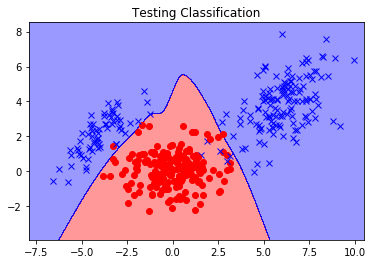

In [155]:
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    for step in range(1, epochs+1):
        batch_x, batch_y = x_train, y_train_onehot
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={X: batch_x, Y: batch_y})
        if step % display_step == 0 or step == 1:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,
                                                                 Y: batch_y})
            l.append(acc)
            valid_loss, valid_acc = sess.run([loss_op, accuracy], feed_dict={X: x_valid,
                                                                             Y: y_valid_onehot})
            print("Step " + str(step) + ", Training Loss= " + \
                  "{:.4f}".format(loss) + " & Accuracy= " + \
                  "{:.3f}".format(acc) + " || Validation Loss= " + \
                  "{:.4f}".format(valid_loss) + " & Accuracy= " + \
                  "{:.3f}".format(valid_acc))

    print("Optimization Finished!")

    # Calculate accuracy for MNIST test images
    test_acc = sess.run(accuracy, feed_dict={X: x_test,Y: y_test_onehot})
    print("Testing Accuracy : {}".format(test_acc))
    
    predictions = sess.run(tf.argmax(logits,1), feed_dict = {X: x_test})
    
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y_train))])
    resolution = 0.02
    # plot the decision surface
    x1_min, x1_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
    x2_min, x2_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = sess.run(tf.argmax(logits,1), feed_dict = {X: (np.array([xx1.ravel(), xx2.ravel()]).T)})
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap) # Displays classification region
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    plotdata(x_test,y_test)
    plt.title("Testing Classification")

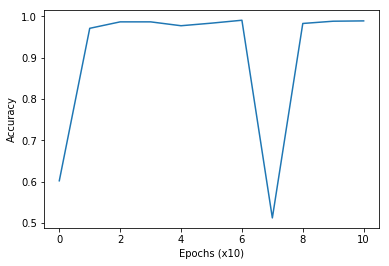

In [158]:
plt.plot(l)
plt.xlabel("Epochs (x10)")
plt.ylabel("Accuracy")
plt.show()